## Everlasting Options: Pricing and Greeks Analysis
**Objective**: In this notebook we're analyzing the pricing and greeks of an everlasting option. Please refer to this [paper](https://www.paradigm.xyz/2021/05/everlasting-options/) by [Dave White](https://twitter.com/_Dave__White_) and [Sam Bankman-Fried](https://twitter.com/SBF_Alameda) for the exact details and methodology. 

In [1]:
# Load libraries
from py_vollib.black_scholes.greeks.numerical import delta, gamma, theta, vega
from py_vollib.black_scholes import black_scholes as bs
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class EverlastingOption:
    def __init__(self, spot, strike, vol, option_type):
        """
        Parameters:
        -----------
        spot: the spot price of the underlying asset
        strike: the strike price of the option
        vol: the implied volatility of the option (assuming same volatility for all maturities)
        option_type: choose between 'c' or 'p'
        """
        self.spot = spot
        self.strike = strike
        self.vol = vol
        self.option_type = option_type
        # 'self.maturities' represents the days until the option expires
        # In this case we look at options between 1 to 20 days to expiry
        self.maturities = np.arange(1, 21, 1)
        # Weigh the options accordingly (ie: 50%, 25%, 12.5% etc...)
        self.weights = 0.50**self.maturities
    
    def price(self, return_individual=False):
        """
        Returns the price of the everlasting option.
        
        Parameters:
        -----------
        return_individual: bool
            Returns the individual option prices which make up the everlasting option price if set to "True"
        """
        # We're limiting our analysis by only looking at 20 sequential option maturities        
        option_prices = [bs(flag=self.option_type,
                               S=self.spot,
                               K=self.strike,
                               t=mat/365,
                               r=0,
                               sigma=self.vol) for mat in self.maturities]
        
        # Return the single everlasting option price
        if return_individual==False:            
            return sum(option_prices*self.weights)
        
        # Return the basket of individual option prices which make up the everlasting option
        elif return_individual==True:
            return option_prices

    def greeks(self, return_individual=False):
        """
        Returns the greeks of an everlasting option
        
        Parameters:
        -----------
        return_individual: bool
            Returns the individual option greeks of an everlasting option if set to "True"
        """
        # Calculate the individual option gamma for all expiries
        g = np.array([gamma(flag=self.option_type,
                             S=self.spot,
                             K=self.strike,
                             t=mat/365,
                             r=0,            
                             sigma=self.vol) for mat in self.maturities])
        
        # Calculate the individual option delta for all expiries
        d = np.array([delta(flag=self.option_type,
                             S=self.spot,
                             K=self.strike,
                             t=mat/365,
                             r=0,
                             sigma=self.vol) for mat in self.maturities])

        # Calculate the individual option vega for all expiries
        v = np.array([vega(flag=self.option_type,
                             S=self.spot,
                             K=self.strike,
                             t=mat/365,
                             r=0,
                             sigma=self.vol) for mat in self.maturities])

        # Calculate the individual option theta for all expiries
        t = np.array([theta(flag=self.option_type,
                             S=self.spot,
                             K=self.strike,
                             t=mat/365,
                             r=0,
                             sigma=self.vol) for mat in self.maturities])

        # Calculate the everlasting option greeks
        option_gamma = sum(g*self.weights)
        option_vega  = sum(v*self.weights)
        option_theta = sum(t*self.weights)
        option_delta = sum(d*self.weights)
        
        # Return the everlasting option greeks
        if return_individual == False:
            return option_gamma, option_vega, option_theta, option_delta
        
        # Return greeks for options in the basket of the everlasting option
        elif return_individual == True:
            return g, v, t, d
    

### Part 1: Analyze Impact Of Volatility On Everlasting Options
In this analysis we'll compare how extreme changes in volatility can impact the price of an everlasting option. For this example, we'll calculate the price of an everlasting option across different volatility regimes. The purpose of this will be to isolate the effect of implied volatility and analyze its direct impact on the price of an everlasting option.

In this example, we're assuming the funding fee is paid once a day. As a result, based on the math behind the everlasting options, the average time to expiry will be $2N$ where $N$ is how often the funding is paid. Therefore, if we're paying funding once per day, then the everlasting option would have an average time to expiry of 2 days (ie: 2 x 1 day = 2 days). For this reason, to accurately compare any changes in the everlasting option we must use a 2 day option for proper analysis.

In [3]:
# Generate a range of spot prices ranging from $70 to $150
spot_range = range(70, 151, 1)

# Calculate the price of an everlasting $100 strike call option priced at 100% IV
c1 = [EverlastingOption(spot=i, strike=100, vol=1.00, option_type='c').price() for i in spot_range]
# Calculate the price of a vanilla $100 strike 2 day call option priced at 100% IV
c_1 = [EverlastingOption(spot=i, strike=100, vol=1.00, 
                         option_type='c').price(return_individual=True)[1] for i in spot_range]

# Calculate the price of an everlasting $100 strike call option priced at 500% IV
c5 = [EverlastingOption(spot=i, strike=100, vol=5.00, option_type='c').price() for i in spot_range]
# Calculate the price of a vanilla $100 strike 2 day call option priced at 500% IV
c_5 = [EverlastingOption(spot=i, strike=100, vol=5.00, 
                         option_type='c').price(return_individual=True)[1] for i in spot_range]

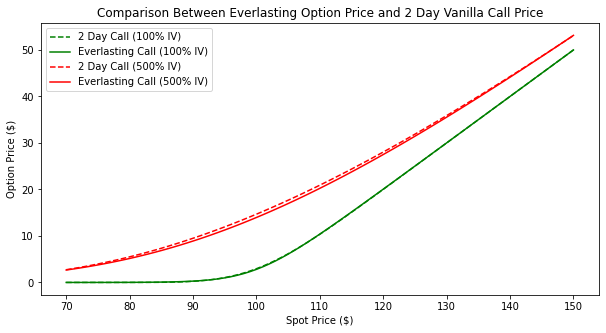

In [4]:
plt.figure(figsize=(10, 5))
plt.plot(spot_range, c_1, label='2 Day Call (100% IV)', linestyle='--', c='g')
plt.plot(spot_range, c1, label='Everlasting Call (100% IV)', linestyle='-', c='g')

plt.plot(spot_range, c_5, label='2 Day Call (500% IV)', linestyle='--', c='r')
plt.plot(spot_range, c5, label='Everlasting Call (500% IV)', linestyle='-', c='r')

plt.xlabel("Spot Price ($)")
plt.ylabel("Option Price ($)")
plt.legend()
plt.title("Comparison Between Everlasting Option Price and 2 Day Vanilla Call Price");
plt.savefig("figures/everlasting_vanilla_compare.png", dpi=300)

When we price both the everlasting and 2 day call option with 100% IV, the difference between the option prices are quite small (notice how the solid green line and dashed green line are overlapping each other). Similarly, when we price the same options with 500% IV, the difference between the option prices are still relatively similar.

### Part 2: Analyze Greeks Of Everlasting Option
In this analysis we will simply look at the individual greeks for each option which make up the everlasting option. For example, in our case we're using 20 individual options as an approximation to determine the price of a single everlasting option. Each option will have its own greek risks, therefore, we can see how much each option contributes towards the cumulative greek risks.

In [5]:
# Initialize the 'EverlastingOption' class with the following parameters:
# Spot = $100 / Strike = $100 / IV = 100% / Option Type = "Call"
x = EverlastingOption(spot=100, strike=100, vol=1, option_type='c')

# Get the individual greeks for each option which make up a single everlasting option
data = x.greeks(return_individual=True)
# Extract the greeks for each individual option
gamma_values, vega_values, theta_values, delta_values = data[0], data[1], data[2], data[3]
# Create the weights and maturities variables
weights = x.weights
maturities = x.maturities

# Calculate the greek contribution for each option in the basket
delta_weight = (np.cumsum(delta_values*weights)/sum(delta_values*weights))*100
vega_weight = (np.cumsum(vega_values*weights)/sum(vega_values*weights))*100
gamma_weight = (np.cumsum(gamma_values*weights)/sum(gamma_values*weights))*100
theta_weight = (np.cumsum(theta_values*weights)/sum(theta_values*weights))*100

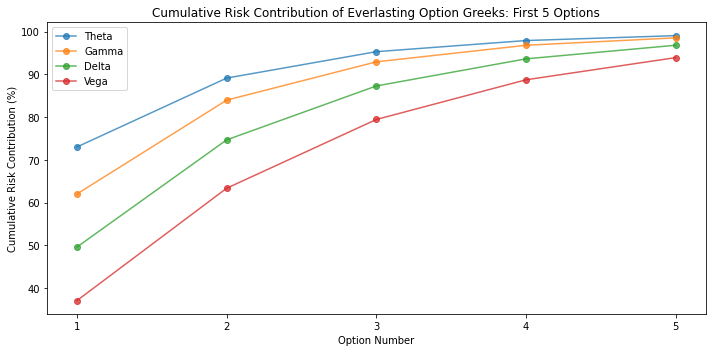

In [6]:
# Plot the data for the first 5 options 
plt.figure(figsize=(10, 5))
plt.plot(maturities[:5], theta_weight[:5], alpha=0.75, label='Theta', marker='o')
plt.plot(maturities[:5], gamma_weight[:5], alpha=0.75, label='Gamma', marker='o')
plt.plot(maturities[:5], delta_weight[:5], alpha=0.75, label='Delta', marker='o')
plt.plot(maturities[:5], vega_weight[:5], alpha=0.75, label='Vega', marker='o')

plt.xlabel("Option Number")
plt.ylabel("Cumulative Risk Contribution (%)")
plt.title("Cumulative Risk Contribution of Everlasting Option Greeks: First 5 Options")
plt.xticks(maturities[:5])
plt.legend()
plt.tight_layout()
plt.savefig("figures/greek_risk_contribution.png", dpi=300)

With this visualization we are able to see which greeks are most exposed to the first few options comprising the everlasting option. Let's take a look at each individual greek.

- **Theta**: Even though the 1 day call option has a weight of 50% in the everlasting option, roughly 70% of the total theta risk is concentrated in this single maturity. This makes intuitive sense because short-dated options tend to have very rapid time decay, hence the larger exposure to theta.

- **Gamma**: Roughly 60% of the everlasting option's gamma exposure comes from the daily option. This is a similar to the discussion about theta as short-dated options tend to have large gamma exposures.

- **Delta**: Around 50% of the total everlasting option delta exposure comes from the daily option. Perhaps this is because we're assuming constant implied volatility for all options which causes delta to be relatively similar across all maturities.

- **Vega**: Only 35% of the vega exposure for the everlasting option comes from the 1 day call option. The reason for this could be because vega tends to be larger for longer-dated options (ie: short-dated options have high gamma whereas longer-dated options have higher vega). For this reason longer-dated options are likely given more weight which results in the 1 day option to have less vega exposure.